# Определение возраста покупателей

### Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

* Контролировать добросовестность кассиров при продаже алкоголя.

---
    
<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Описание-проекта">Описание проекта</a></li>
    <li><a href="#Цели-и-задачи">Цели и задачи</a></li>
    <li><a href="#Исследовательский-анализ-данных">Исследовательский анализ данных</a></li>
    <li><a href="#Обучение-модели">Обучение модели</a></li>
    <li><a href="#Анализ-обученной-модели">Анализ обученной модели</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - Построить модель, которая по фотографии определит приблизительный возраст человека.

**Задачи**:
    
    1. Провести исследовательский анализ набора фотографий.
    2. Подготовить данные к обучению.
    3. Обучить нейронную сеть и рассчитать её качество.
    4. Провести анализ обученной модели.
---

## Исследовательский анализ данных

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D, Dense
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=12345)

Found 7591 validated image filenames.


In [5]:
labels.info()
labels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
labels.shape

(7591, 2)

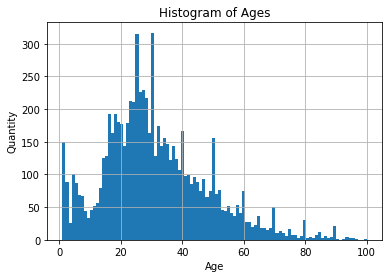

In [12]:
labels.hist(bins=100)
plt.title("Histogram of Ages")
plt.xlabel("Age")
plt.ylabel("Quantity")
plt.show()

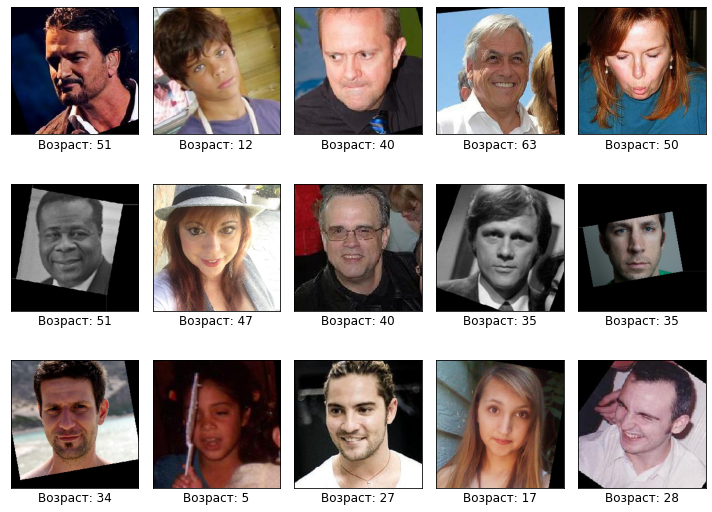

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Возраст: ' + str(target[i]), fontsize=12)
    plt.tight_layout()

#### Вывод

 - В датасете 7591 фотографий

 - Основная часть датасета, фото в возрасте людей от 16 до 40 лет

 - Есть ЧБ фотографии, под углом, разных размеров, к тому же есть фото с лишними объектами перед лицом (очки, микрофон, головной убор закрывающий лицо и пр.), возможно растительность на лице тоже повлияет на обучение модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 horizontal_flip=True,
                                 validation_split=0.2)
    train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='training',
                                                 seed=12345)
     return train_gen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='validation',
                                                seed=12345)
    return test_gen_flow


def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001) 
    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='imagenet') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4, activation='relu')) 
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=5,
                steps_per_epoch=None, 
                validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    return model
```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 76s - loss: 291.4233 - mae: 12.3212 - val_loss: 960.9280 - val_mae: 26.1005
Epoch 2/5
190/190 - 47s - loss: 80.5444 - mae: 6.7653 - val_loss: 473.4517 - val_mae: 16.3891
Epoch 3/5
190/190 - 46s - loss: 53.6212 - mae: 5.5909 - val_loss: 208.9423 - val_mae: 10.5909
Epoch 4/5
190/190 - 50s - loss: 39.0281 - mae: 4.7862 - val_loss: 113.6823 - val_mae: 7.8894
Epoch 5/5
190/190 - 49s - loss: 30.0807 - mae: 4.1981 - val_loss: 77.8634 - val_mae: 6.9256

48/48 - 8s - loss: 77.8634 - mae: 6.9256
Test MAE: 6.9256

```

## Анализ обученной модели

* Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью

* Была использована модель сверточной нейронной сети на ResNet50, применен алгоритм обучения нейронной сети Adam

* MAE за 5 эпох удалось уменьшить с 12.3 до 4.2

* Полученная модель может определять приблизительный возраст человека

* Погрешность модели при определении возраста составляет примерно в 7 лет

